<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex06/Hugo_Abonizio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento de uma CNN no CIFAR 10

In [1]:
nome = 'Hugo Abonizio'

print(f'Meu nome é {nome}')

Meu nome é Hugo Abonizio


Este exercicío consiste em implementar e treinar no CIFAR-10 vários blocos de uma Resnet seguido de uma camada linear de classificação.

## Importação das bibliotecas

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

## Fixando as seeds

In [3]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [4]:
batch_size = 50

## Download do CIFAR-10

In [5]:
!mkdir ./data

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)


mkdir: cannot create directory ‘./data’: File exists
Files already downloaded and verified
Files already downloaded and verified


## Criação do dataloader

In [6]:
train_size = 40000
val_size = 10000
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [7]:
batch_size = 50

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))

x_train, y_train = next(iter(train_dataloader))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 800
Número de minibatches de validação: 200
Número de minibatches de teste: 200

Dimensões dos dados de um minibatch: torch.Size([50, 3, 32, 32])
Valores mínimo e máximo dos pixels:  tensor(-1.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Implementando o Bloco Básico da Resnet

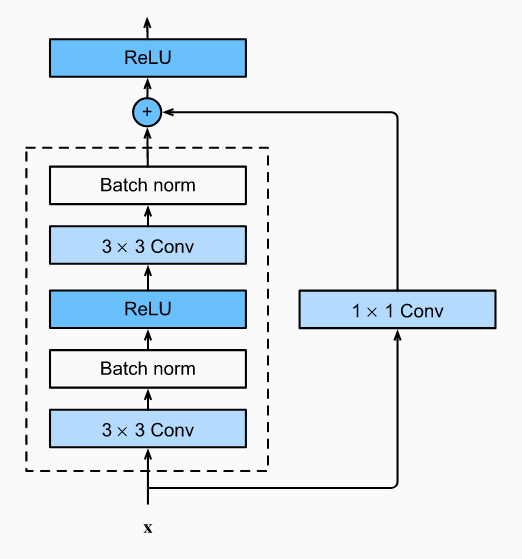

In [8]:
from torch import nn
from torch import Tensor

class MyBasicBlock(nn.Module):
    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
    ) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)
        self.relu = nn.ReLU()


    def forward(self, x: Tensor) -> Tensor:
        out = self.conv1(x)
        out = self.bn1(out)

        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.downsample(x)
        out = self.relu(out)

        return out

## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [9]:
import torchvision

height_in = 5
width_in = 5
inplanes = 2
planes = 3
stride = 2

x = torch.rand(1, inplanes, height_in, width_in)

block = MyBasicBlock(inplanes=inplanes, planes=planes, stride=stride)

downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)

block_pt = torchvision.models.resnet.BasicBlock(inplanes=inplanes, planes=planes, stride=stride, downsample=downsample)

# Usa os mesmos pesos para minha implementação e a do pytorch
block.load_state_dict(block_pt.state_dict())

out = block(x)
target_out = block_pt(x)

print(f'out:\n{out}')
print(f'target_out:\n{target_out}')

assert torch.allclose(out, target_out, atol=1e-6)

out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)
target_out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)


## Modelo

Implemente um modelo de classificação que será treinado no CIFAR-10.

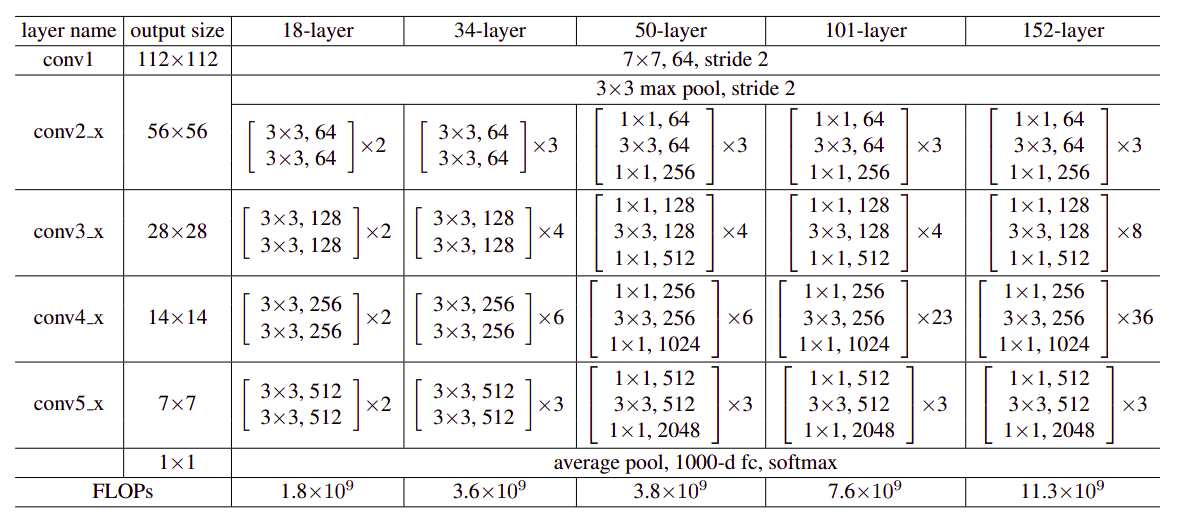

In [15]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        self.layer1 = MyBasicBlock(inplanes=64, planes=64)
        self.layer2 = MyBasicBlock(inplanes=64, planes=128)
        self.layer3 = MyBasicBlock(inplanes=128, planes=256)
        self.layer4 = MyBasicBlock(inplanes=256, planes=512)

        self.classifier = nn.Linear(512, 10)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, start_dim=1)
        out = self.classifier(out)
        return out

In [26]:
print(torch.flatten(nn.MaxPool2d((1,1))(torch.rand(2, 3, 3, 3)), 1).shape)
print(torch.flatten(nn.AdaptiveAvgPool2d((1,1))(torch.rand(2, 3, 3, 3)), 1).shape)

torch.Size([2, 27])
torch.Size([2, 3])


## Treinamento

### Definição dos hiperparâmetros

In [11]:
n_epochs = 20
lr = 0.1

### Detectando a GPU

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
@torch.no_grad()
def evaluation(model, loader):
    model.eval()
    correct = 0
    total = 0
    for (inputs, targets) in tqdm(loader, desc='Validation'):
      inputs = inputs.to(device)
      targets = targets.to(device)
      outputs = model(inputs)
      correct += (outputs.argmax(dim=1) == targets).sum().item()
      total += len(targets)
    
    mean_accuracy = correct / total
    print(f'Accuracy: {(mean_accuracy * 100):.2f}%')
    return mean_accuracy

### Laço de treinamento

In [16]:
from tqdm import tqdm

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


model = Net()

best_accuracy = 0

print('Parameters', count_parameters(model))

model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0

# Primeira avaliação com pesos aleatórios
evaluation(model=model, loader=val_dataloader)

for i in range(n_epochs):
    model.train()
    for x_train, y_train in tqdm(train_dataloader, total=len(train_dataloader), desc='Training'):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(train_dataset))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')

    # Chama a função de validação no final de cada época
    val_accuracy = evaluation(model=model, loader=val_dataloader)
    if val_accuracy > best_accuracy:
      best_accuracy = val_accuracy
      torch.save(model, 'best_model.pt')
    scheduler.step()

Parameters 4913226


Validation: 100%|██████████| 200/200 [00:03<00:00, 52.90it/s]


Accuracy: 11.02%


Training: 100%|██████████| 800/800 [00:20<00:00, 38.90it/s]


Epoch: 0/19 Loss: 1.2638322114944458


Validation: 100%|██████████| 200/200 [00:03<00:00, 61.13it/s]


Accuracy: 55.50%


Training: 100%|██████████| 800/800 [00:20<00:00, 38.79it/s]


Epoch: 1/19 Loss: 1.155524730682373


Validation: 100%|██████████| 200/200 [00:04<00:00, 47.20it/s]


Accuracy: 66.57%


Training: 100%|██████████| 800/800 [00:20<00:00, 38.60it/s]


Epoch: 2/19 Loss: 0.6638139486312866


Validation: 100%|██████████| 200/200 [00:03<00:00, 62.24it/s]


Accuracy: 69.37%


Training: 100%|██████████| 800/800 [00:20<00:00, 39.33it/s]


Epoch: 3/19 Loss: 0.6657536029815674


Validation: 100%|██████████| 200/200 [00:03<00:00, 62.76it/s]


Accuracy: 72.56%


Training: 100%|██████████| 800/800 [00:20<00:00, 39.27it/s]


Epoch: 4/19 Loss: 0.6733107566833496


Validation: 100%|██████████| 200/200 [00:03<00:00, 61.78it/s]


Accuracy: 73.37%


Training: 100%|██████████| 800/800 [00:20<00:00, 38.93it/s]


Epoch: 5/19 Loss: 0.5448660850524902


Validation: 100%|██████████| 200/200 [00:03<00:00, 61.85it/s]


Accuracy: 80.91%


Training: 100%|██████████| 800/800 [00:20<00:00, 39.11it/s]


Epoch: 6/19 Loss: 0.33929643034935


Validation: 100%|██████████| 200/200 [00:03<00:00, 61.18it/s]


Accuracy: 81.28%


Training: 100%|██████████| 800/800 [00:20<00:00, 38.89it/s]


Epoch: 7/19 Loss: 0.22111481428146362


Validation: 100%|██████████| 200/200 [00:03<00:00, 60.21it/s]


Accuracy: 80.99%


Training: 100%|██████████| 800/800 [00:20<00:00, 39.08it/s]


Epoch: 8/19 Loss: 0.26004844903945923


Validation: 100%|██████████| 200/200 [00:03<00:00, 62.01it/s]


Accuracy: 81.03%


Training: 100%|██████████| 800/800 [00:20<00:00, 38.87it/s]


Epoch: 9/19 Loss: 0.2152995616197586


Validation: 100%|██████████| 200/200 [00:03<00:00, 61.30it/s]


Accuracy: 80.66%


Training: 100%|██████████| 800/800 [00:20<00:00, 39.06it/s]


Epoch: 10/19 Loss: 0.22383847832679749


Validation: 100%|██████████| 200/200 [00:03<00:00, 61.70it/s]


Accuracy: 81.45%


Training: 100%|██████████| 800/800 [00:20<00:00, 39.17it/s]


Epoch: 11/19 Loss: 0.22189635038375854


Validation: 100%|██████████| 200/200 [00:03<00:00, 59.76it/s]


Accuracy: 81.30%


Training: 100%|██████████| 800/800 [00:20<00:00, 38.60it/s]


Epoch: 12/19 Loss: 0.2842593491077423


Validation: 100%|██████████| 200/200 [00:03<00:00, 61.30it/s]


Accuracy: 81.48%


Training: 100%|██████████| 800/800 [00:20<00:00, 39.12it/s]


Epoch: 13/19 Loss: 0.14383751153945923


Validation: 100%|██████████| 200/200 [00:03<00:00, 61.78it/s]


Accuracy: 81.49%


Training: 100%|██████████| 800/800 [00:20<00:00, 38.80it/s]


Epoch: 14/19 Loss: 0.3072074055671692


Validation: 100%|██████████| 200/200 [00:03<00:00, 61.37it/s]


Accuracy: 81.48%


Training: 100%|██████████| 800/800 [00:25<00:00, 31.06it/s]


Epoch: 15/19 Loss: 0.13656413555145264


Validation: 100%|██████████| 200/200 [00:03<00:00, 60.78it/s]


Accuracy: 81.40%


Training: 100%|██████████| 800/800 [00:20<00:00, 38.93it/s]


Epoch: 16/19 Loss: 0.26059237122535706


Validation: 100%|██████████| 200/200 [00:03<00:00, 60.73it/s]


Accuracy: 81.55%


Training: 100%|██████████| 800/800 [00:20<00:00, 39.33it/s]


Epoch: 17/19 Loss: 0.1817285418510437


Validation: 100%|██████████| 200/200 [00:04<00:00, 49.56it/s]


Accuracy: 81.54%


Training: 100%|██████████| 800/800 [00:20<00:00, 39.22it/s]


Epoch: 18/19 Loss: 0.22035515308380127


Validation: 100%|██████████| 200/200 [00:03<00:00, 62.63it/s]


Accuracy: 81.54%


Training: 100%|██████████| 800/800 [00:20<00:00, 38.74it/s]


Epoch: 19/19 Loss: 0.21480417251586914


Validation: 100%|██████████| 200/200 [00:03<00:00, 61.61it/s]

Accuracy: 81.45%


### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

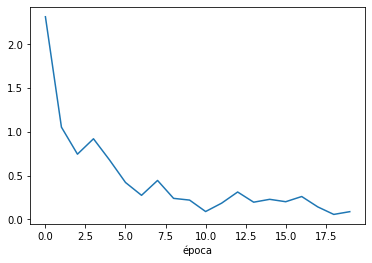

In [17]:
n_batches_train = len(train_dataloader)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

## Avaliação final no dataset de testes

In [18]:
model = torch.load('best_model.pt')
evaluation(model=model, loader=test_dataloader) # era 0.735

Validation: 100%|██████████| 200/200 [00:03<00:00, 56.61it/s]

Accuracy: 81.39%


0.8139

# Bonus Opcional

## Implementando o Dropout

In [19]:
class MyDropout(torch.nn.Module):
    def __init__(self, p: float):
        super().__init__()
        self.p = p

    def forward(self, x, training: bool):
        # https://stackoverflow.com/questions/54109617/implementing-dropout-from-scratch
        if training:
          q = 1 - self.p
          binomial = torch.distributions.binomial.Binomial(probs=q)
          # "Inverted dropout is a bit different. This approach consists in the scaling of the
          # activations during the training phase, leaving the test phase untouched"
          return x * binomial.sample(x.shape) / q

        return x

## Mostre que sua implementação traz resultados semelhantes à implementação do pytorch

In [20]:
import math

p = 0.5
dropout = MyDropout(p=p)

x = torch.rand(16, 3, 32, 32)

out = dropout(x, training=True)
out_pt = torch.nn.functional.dropout(x, p=p, training=True)

mean_zeros = (out == 0).sum() / out.numel()
mean_zeros_pt = (out_pt == 0).sum() / out_pt.numel()

print(f'mean zeros: {mean_zeros}')
print(f'mean zeros pytorch: {mean_zeros_pt}')

assert math.isclose(mean_zeros, mean_zeros_pt, abs_tol=1e-2)

out = dropout(x, training=False)
target_out = torch.nn.functional.dropout(x, p=p, training=False, inplace=False)
assert torch.allclose(out, target_out, atol=1e-6)

mean zeros: 0.5018513798713684
mean zeros pytorch: 0.5020548701286316
